<a href="https://colab.research.google.com/github/mtzig/LIDC_GDRO/blob/main/notebooks/LIDC_malig_subgroup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %cd ..
!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd /content/LIDC_GDRO

Cloning into 'LIDC_GDRO'...
remote: Enumerating objects: 3577, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 3577 (delta 85), reused 76 (delta 35), pack-reused 3428
Receiving objects: 100% (3577/3577), 68.54 MiB | 15.75 MiB/s, done.
Resolving deltas: 100% (3233/3233), done.
Checking out files: 100% (5400/5400), done.
/content/LIDC_GDRO


In [ ]:
# !git pull

remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 8 (delta 6), reused 8 (delta 6), pack-reused 0
Unpacking objects: 100% (8/8), done.
From https://github.com/mtzig/LIDC_GDRO
   44d8b03..bf33e58  main       -> origin/main
Updating 44d8b03..bf33e58
Fast-forward
 data/LIDC_data_split.csv            | 1489 +++++++++++++++++++++++++++++++++++
 image_data_utils.py                 |   42 +-
 notebooks/LIDC_clusters.ipynb       |  104 ++-
 notebooks/LIDC_malig_subgroup.ipynb |   55 +-
 4 files changed, 1614 insertions(+), 76 deletions(-)
 create mode 100644 data/LIDC_data_split.csv


In [3]:
import pandas as pd
# import numpy as np
from dataloaders import InfiniteDataLoader
from datasets import NoduleDataset, SubclassedNoduleDataset
from models import TransferModel
from loss import ERMLoss, GDROLossAlt#, GDROLoss
from train import train, test
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
# import torchvision
from torchvision import transforms
import torch
from image_data_utils import getImages

In [7]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Using cpu")
    DEVICE = torch.device("cpu")

Good to go!


In [10]:
train_data, cv_data, test_data = getImages(split=True, sublabels=True, binary=True, device=DEVICE)

In [29]:
import numpy as np
def split_data(data):
  X,y,c = data
  X = torch.stack(X)
  y = torch.stack(y)
  c = torch.tensor(np.stack(c), device=DEVICE)

  subclassed = []
  for i in range(4):
    idx = (c == i)
    subclassed.append((torch.unbind(X[idx]),torch.unbind(y[idx]),torch.unbind(c[idx])))

  X_0, y_0, c_0 = subclassed[0]
  X_3, y_3, c_3 = subclassed[3]

  data_1 = (X_0+X_3,y_0+y_3,c_0+c_3)

  X_1, y_1, c_1 = subclassed[1]
  X_2, y_2, c_2 = subclassed[2]
  data_2 = (X_1+X_2,y_1+y_2,c_1+c_2)

  return data_1, data_2

In [30]:
train_1, train_2 = split_data(train_data)
cv_1, cv_2 = split_data(cv_data) 

In [31]:
# tr = SubclassedNoduleDataset(*train_data)
# cv = SubclassedNoduleDataset(*cv_data)
tst = SubclassedNoduleDataset(*test_data)
# tr_loader = InfiniteDataLoader(tr, batch_size=512)
# cv_loader = InfiniteDataLoader(cv, len(cv))
tst_loader = InfiniteDataLoader(tst, len(tst))

In [32]:
tr1 =  SubclassedNoduleDataset(*train_1)
tr1_loader = InfiniteDataLoader(tr1, batch_size=128)

cv1 = SubclassedNoduleDataset(*cv_1)
cv1_loader = InfiniteDataLoader(cv1 , len(cv1))

In [42]:
tr2 =  SubclassedNoduleDataset(*train_2)
tr2_loader = InfiniteDataLoader(tr2, batch_size=128)

cv2 = SubclassedNoduleDataset(*cv_2)
cv2_loader = InfiniteDataLoader(cv2 , len(cv2))

In [73]:
model = TransferModel(device=DEVICE, pretrained=True, freeze=False)
loss_fn = ERMLoss(model,torch.nn.CrossEntropyLoss(),{}, subclassed=True)
# loss_fn = GDROLossAlt(model,torch.nn.CrossEntropyLoss(),0.5,4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)#lr=0.001, weight_decay=0.005)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#train function

In [34]:
def train_epochs(epochs, train_loader, val_loader, model, loss_fn, optimizer,scheduler, verbose=True):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train(train_loader, model, loss_fn, optimizer, verbose=verbose)
        accuracies = test(val_loader, model, verbose=verbose)
        scheduler.step(accuracies[0])

In [74]:
train_epochs(7,tr1_loader,cv1_loader,model,loss_fn,optimizer,scheduler)

Epoch 1/7
Average training loss: 0.34452221741278966
Accuracy: 0.875 
Accuracy over subgroups: [0.8 nan nan 1. ] 
Worst Group Accuracy: 0.8
Epoch 2/7


/content/LIDC_GDRO/train.py:52: RuntimeWarning: invalid value encountered in true_divide
  subgroup_accuracy = subgroup_correct / num_samples


Average training loss: 0.13066299843291443
Accuracy: 0.9464285714285714 
Accuracy over subgroups: [0.90909091        nan        nan 1.        ] 
Worst Group Accuracy: 0.9090909090909091
Epoch 3/7
Average training loss: 0.06766451591004928
Accuracy: 0.9107142857142857 
Accuracy over subgroups: [0.88235294        nan        nan 0.95454545] 
Worst Group Accuracy: 0.8823529411764706
Epoch 00003: reducing learning rate of group 0 to 1.0000e-04.
Epoch 4/7
Average training loss: 0.047887032354871434
Accuracy: 0.9285714285714286 
Accuracy over subgroups: [0.91891892        nan        nan 0.94736842] 
Worst Group Accuracy: 0.918918918918919
Epoch 5/7
Average training loss: 0.02736619490509232
Accuracy: 0.9642857142857143 
Accuracy over subgroups: [0.97297297        nan        nan 0.94736842] 
Worst Group Accuracy: 0.9473684210526315
Epoch 6/7
Average training loss: 0.013901260743538538
Accuracy: 0.8571428571428571 
Accuracy over subgroups: [0.77419355        nan        nan 0.96      ] 
Worst Gr

In [76]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.000005, weight_decay=0.005)#lr=0.001, weight_decay=0.005)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)

In [77]:
train_epochs(7,tr2_loader,cv2_loader,model,loss_fn,optimizer,scheduler)

Epoch 1/7
Average training loss: 1.1981044054031371
Accuracy: 0.7912087912087912 
Accuracy over subgroups: [       nan 0.80357143 0.77142857        nan] 
Worst Group Accuracy: nan
Epoch 2/7


/content/LIDC_GDRO/train.py:52: RuntimeWarning: invalid value encountered in true_divide
  subgroup_accuracy = subgroup_correct / num_samples


Average training loss: 1.041552290916443
Accuracy: 0.7142857142857143 
Accuracy over subgroups: [       nan 0.83333333 0.54054054        nan] 
Worst Group Accuracy: nan
Epoch 3/7
Average training loss: 0.8520466828346253
Accuracy: 0.8131868131868132 
Accuracy over subgroups: [       nan 0.87037037 0.72972973        nan] 
Worst Group Accuracy: nan
Epoch 4/7
Average training loss: 0.7380579686164856
Accuracy: 0.7802197802197802 
Accuracy over subgroups: [       nan 0.81355932 0.71875           nan] 
Worst Group Accuracy: nan
Epoch 5/7
Average training loss: 0.6217018151283265
Accuracy: 0.8241758241758241 
Accuracy over subgroups: [       nan 0.87878788 0.68              nan] 
Worst Group Accuracy: nan
Epoch 6/7
Average training loss: 0.5110741913318634
Accuracy: 0.7252747252747253 
Accuracy over subgroups: [       nan 0.79245283 0.63157895        nan] 
Worst Group Accuracy: nan
Epoch 7/7
Average training loss: 0.456613734960556
Accuracy: 0.7912087912087912 
Accuracy over subgroups: [    

In [78]:
test(tst_loader, model, verbose=True)

Accuracy: 0.813953488372093 
Accuracy over subgroups: [0.91139241 0.80373832 0.64383562 0.95238095] 
Worst Group Accuracy: 0.6438356164383562


(0.813953488372093,
 0.9113924050632911,
 0.8037383177570093,
 0.6438356164383562,
 0.9523809523809523)

## function to run 50 trials

In [ ]:
def run_trials(runs,epochs, train_loader, val_loader, test_loader, loss_fn_type, verbose=True, model=None, save_weights=False):
  all_accuracies = []
  for run in range(runs):
    print(f'Run {run+1}/{runs}')
    if not model:
      model = TransferModel(device=DEVICE, pretrained=True, freeze=False)
    else:
      model = model

    if save_weights:
      weight_path = os.path.join('/content', 'LIDC_GDRO', 'weights')
      torch.save(model.state_dict(), weight_path) #saves weights in file called weights
    if loss_fn_type == 'ERM':
      loss_fn = ERMLoss(model,torch.nn.CrossEntropyLoss(),{}, subclassed=True)
    else:
      loss_fn = GDROLossAlt(model,torch.nn.CrossEntropyLoss(),0.01,4)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=verbose)    
    train_epochs(epochs, train_loader, val_loader, model, loss_fn, optimizer,scheduler, verbose=verbose)

    accuracies = test(test_loader, model, verbose=False)


    print(f'1 accuracy: {accuracies[1]:.3f}')
    print(f'2 accuracy: {accuracies[2]:.3f}')
    print(f'4 accuracy: {accuracies[3]:.3f}')
    print(f'5 accuracy: {accuracies[4]:.3f}')

    print(f'Total accuracy: {accuracies[0]:.3f}')
    all_accuracies.append(accuracies)

  return all_accuracies

def plot_accuracies(all_accuracies, download_name):
  accuracies = list(map(lambda x:(float(i) for i in x), all_accuracies))
  df = pd.DataFrame(accuracies, columns = ['entire', '1', '2', '4', '5'])

  df.to_csv(download_name)
  return df.boxplot(column=['1', '2', '4', '5', 'entire'], figsize = (10,10))




#Run ERM with only malignancy 1 and malignancy 5

In [ ]:
all_accuracies = run_trials(50,15, tr1_loader, cv1_loader, tst_loader, 'ERM', verbose=False)
boxplot = plot_accuracies(all_accuracies, 'cnn_erm1_accuracies.csv')

#First we run ERM trials

In [ ]:
all_accuracies = run_trials(50,15, tr_loader, cv_loader, tst_loader, 'ERM', verbose=False)
boxplot = plot_accuracies(all_accuracies, 'cnn_erm_accuracies.csv')

#Next We run gDRO

In [ ]:
all_accuracies = run_trials(50,15, tr_loader, cv_loader, tst_loader, 'gDRO', verbose=False)
boxplot = plot_accuracies(all_accuracies, 'cnn_gdro_accuracies.csv')

50 trials with same weights

actual 0
Run 1/1


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
1 accuracy: 0.943
2 accuracy: 0.945
4 accuracy: 0.690
5 accuracy: 0.978
Total accuracy: 0.900


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Run 1/1
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
1 accuracy: 0.986
2 accuracy: 0.894
4 accuracy: 0.756
5 accuracy: 0.973
Total accuracy: 0.887
actual 1
Run 1/1
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
1 accuracy: 0.971
2 accuracy: 0.874
4 accuracy: 0.822
5 accuracy: 0.980
Total accuracy: 0.900
Run 1/1
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15
1 accuracy: 0.952
2 accuracy: 0.878
4 accuracy: 0.773
5 accuracy: 1.000
Total accuracy: 0.890
actual 2
Run 1/1
Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14

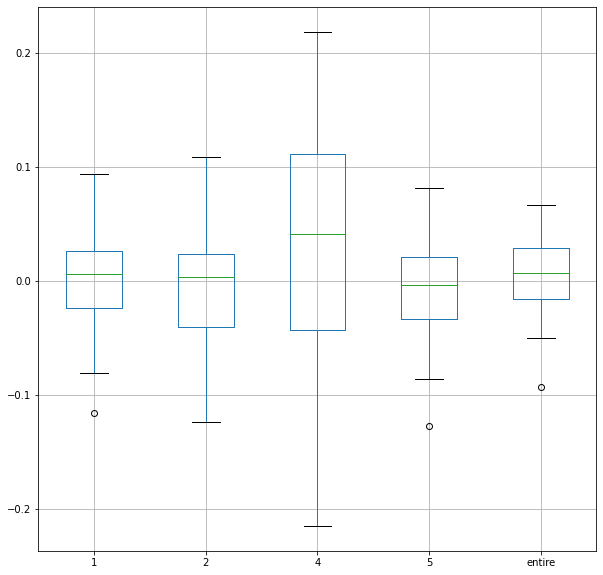

In [ ]:
accs = []
acc_diff = []

for i in range(50):
  print(f'actual {i}')
  accuraciesERM = run_trials(1,15, tr_loader, cv_loader, tst_loader, 'ERM', verbose=False,save_weights=True)[0]
  model = TransferModel(device=DEVICE, pretrained=False, freeze=False) #model with gradients frozen
  weight_path = os.path.join('/content', 'LIDC_GDRO', 'weights')

  model.load_state_dict(torch.load(weight_path, map_location=DEVICE)) #loads it in
  accuraciesGDRO = run_trials(1,15, tr_loader, cv_loader, tst_loader, 'gDRO', verbose=False,model=model)[0]
  accuracies = ((accuraciesERM,accuraciesGDRO))
  accs.append(accuracies)
  acc_diff.append(tuple(map(lambda x: x[1]-x[0], zip(*accuracies) )))

boxplot = plot_accuracies(acc_diff, 'cnn_acc_diff.csv')


#train with same batches

In [ ]:
def train_2(dataloader, models, loss_fns, optimizers, verbose=False):
    num_models = len(models)

    for model in models:
      model.train()

    steps_per_epoch = dataloader.batches_per_epoch()

    avg_losses = [0 for _ in range(num_models)]
    losses = [0 for _ in range(num_models)]
    for i in range(steps_per_epoch):
        
        preds = next(dataloader)
        for i in range(num_models):
         losses[i] = loss_fns[i](preds)
         avg_losses[i] += losses[i].item()

        # avg_loss += loss.item()

        # Backpropagation
        for idx, optimizer in enumerate(optimizers):
          optimizer.zero_grad()
          losses[idx].backward()
          optimizer.step()

    avg_losses = list(map(lambda x:x/steps_per_epoch, avg_losses))

    if verbose:
        print("Average training losses:", avg_losses)

In [ ]:
def train_epochs_2(epochs, train_loader, val_loader, models, loss_fns, optimizers, schedulers, verbose=True):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_2(train_loader, models, loss_fns, optimizers, verbose=verbose)
        accuracies = test(val_loader, model[-1], verbose=verbose)
        for scheduler in schedulers:
          scheduler.step(accuracies[2])

In [ ]:
import copy
def run_trials_2(runs,epochs, train_loader, val_loader, test_loader, verbose=True):
  all_accuracies = []
  for run in range(runs):
    print(f'Run {run+1}/{runs}')
    model_1 = TransferModel(device=DEVICE, pretrained=True, freeze=False)
    
    model_2 = TransferModel(device=DEVICE, pretrained=False, freeze=False)
    model_2.load_state_dict(copy.deepcopy(model_1.state_dict()))



    loss_fn_1 = ERMLoss(model_1,torch.nn.CrossEntropyLoss(),{}, subclassed=True)
    loss_fn_2 = GDROLossAlt(model_2,torch.nn.CrossEntropyLoss(),0.01,4)

    optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.0005, weight_decay=0.005)
    optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.0005, weight_decay=0.005)

    scheduler_1 = ReduceLROnPlateau(optimizer_1, mode='max', factor=0.2, patience=2, verbose=verbose)
    scheduler_2 = ReduceLROnPlateau(optimizer_2, mode='max', factor=0.2, patience=2, verbose=verbose)    

    train_epochs_2(epochs, train_loader, val_loader, (model_1,model_2), (loss_fn_1,loss_fn_2), (optimizer_1,optimizer_2), (scheduler_1, scheduler_2), verbose=verbose)

    accuracies_1 = test(test_loader, model_1, verbose=False)
    accuracies_2 = test(test_loader, model_2, verbose=False)

    accuracies = ((accuracies_1,accuracies_2))
    accs.append(accuracies)
    acc_diff.append(tuple(map(lambda x: x[1]-x[0], zip(*accuracies) )))

    print(f'1 accuracy: {accuracies[0][1]:.3f} {accuracies[1][1]:.3f}')
    print(f'2 accuracy: {accuracies[0][2]:.3f} {accuracies[1][2]:.3f}')
    print(f'4 accuracy: {accuracies[0][3]:.3f} {accuracies[1][3]:.3f}')
    print(f'5 accuracy: {accuracies[0][4]:.3f} {accuracies[1][4]:.3f}')

    print(f'Total accuracy: {accuracies[0][0]:.3f} {accuracies[1][0]:.3f}')
    # all_accuracies.append(accuracies)
    print(accuracies)

  return accs, acc_diff

In [ ]:
accs, acc_diff = run_trials_2(50,15, tr_loader, cv_loader, tst_loader, verbose=True)

Run 1/50


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/15
Average training losses: [0.6006681591272354, 0.6132114440202713]
Epoch 2/15
Average training losses: [0.2830506056547165, 0.27711177319288255]
Epoch 3/15
Average training losses: [0.16020427346229554, 0.16057724356651307]
Epoch 4/15
Average training losses: [0.10053632035851479, 0.10328028053045273]
Epoch 5/15
Average training losses: [0.06779608279466628, 0.06851515471935272]
Epoch 6/15
Average training losses: [0.048093438521027564, 0.04985267408192158]
Epoch 7/15
Average training losses: [0.029710550792515278, 0.031273194774985316]
Epoch 8/15
Average training losses: [0.0211411664262414, 0.022745940648019315]
Epoch 9/15
Average training losses: [0.016675568744540216, 0.01739077754318714]
Epoch 10/15
Average training losses: [0.011811876390129327, 0.012747446727007627]
Epoch 11/15
Average training losses: [0.009149413416162133, 0.009819520637392998]
Epoch 12/15
Average training losses: [0.007794406125321984, 0.008509192941710353]
Epoch 13/15
Average training losses: [0.00

KeyboardInterrupt: ignored